Hallo, Kak Reviewer. 

Perkenalkan, namaku Muhammad Imron, bisa dipanggil Imron. Di submission akhir ini, aku pakai dataset dari Kaggle yang namanya Dataset Zanthoxyli Pericarpium. Dataset itu berupa dataset gambar tanaman herbal dari China yang jumlahnya sekitar 70k,terdiri dari lima kelas. Rencananya di submission ini aku bakalan nerapin image classification buat jenis-jenis tanaman herbal Zanthoxyli Pericarpium. Selain itu, aku juga bakalan nerapin saving model menggunakan TF Lite.

Mohon bantuannya kak, untuk direview.

Terima kasih

---

https://www.kaggle.com/datasets/chaoquntan/image-dataset-of-zanthoxyli-pericarpium

# Download Dataset dari Kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download chaoquntan/image-dataset-of-zanthoxyli-pericarpium --unzip

100% 1.99G/1.99G [00:17<00:00, 127MB/s] 
100% 1.99G/1.99G [00:17<00:00, 124MB/s]


# Persiapan Library

In [8]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPool2D,
    Flatten,
    Input
)
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Data Exploration

Disini aku bakalan cek ada ukuran dataset, size setiap kelas, dan size gambarnya beragam atau ngga

In [11]:
hong_sichuan = [img for img in os.listdir(f'{base_ds}/0hong_sichuan') if img.endswith('.jpg')]
qing_qingjiao = [img for img in os.listdir(f'{base_ds}/1qing_qingjiao') if img.endswith('.jpg')]
qing_tengjiao = [img for img in os.listdir(f'{base_ds}/2qing_tengjiao') if img.endswith('.jpg')]
hong_derong = [img for img in os.listdir(f'{base_ds}/3hong_derong') if img.endswith('.jpg')]
hong_hanyuan = [img for img in os.listdir(f'{base_ds}/4hong_hanyuan') if img.endswith('.jpg')]

herbal = [hong_sichuan, qing_qingjiao, qing_tengjiao, hong_derong, hong_hanyuan]
herbal_classes = []

for i in os.listdir('/content/images/train'):
  herbal_classes+=[i]
herbal_classes.sort()

Total image: 71051
Total number of classes: 5
Total 0hong_sichuan images: 18008
Total 1qing_qingjiao images: 14027
Total 2qing_tengjiao images: 16313
Total 3hong_derong images: 12223
Total 4hong_hanyuan images: 10480


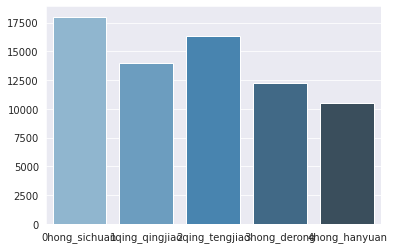

In [12]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total image: {image_count}')
print(f'Total number of classes: {len(herbal_classes)}')
count = 0
herbal_count = []
for i in herbal_classes:
  print(f'Total {i} images: {len(herbal[count])}')
  herbal_count.append(len(herbal[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x = herbal_classes, y = herbal_count, palette = 'Blues_d')
plt.show()

Image dimensions: (634, 485, 3)


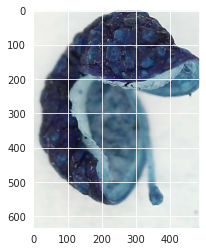

In [13]:
sample_img = cv2.imread('/content/pictures/0hong_sichuan/1000.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

Image dimensions: (456, 636, 3)


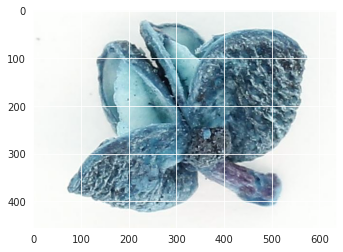

In [14]:
sample_img_2 = cv2.imread('/content/pictures/1qing_qingjiao/10003.jpg')
plt.imshow(sample_img_2)
print(f'Image dimensions: {sample_img_2.shape}')

In [15]:
def load_random_img(dir, label):
  plt.figure(figsize = (10,10))
  i = 0
  for label in herbal_classes:
    i += 1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    image = cv2.imread(image_path)
    plt.title(label)
    plt.imshow(image)
    plt.grid(None)
    plt.axis('off')

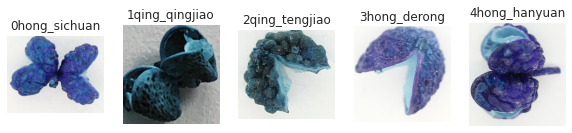

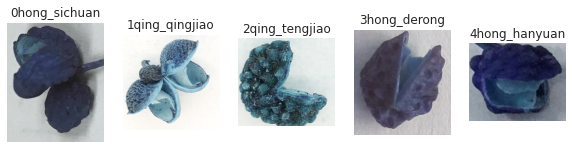

In [16]:
for i in range(2):
  load_random_img(base_ds, herbal_classes)

# Splitting Train dan Test

Karena datasetnya berupa gambar, dari sepengetahuanku ada dua pilihan buat split folder gambar, bisa pakai library splitfolders atau validation_split di Image Generator. Di submission ini aku nerapin splitfolders dengan ratio sesuai kriteria submission, 0.8 untuk training, dan 0.2 untuk validation

In [10]:
base_ds = pathlib.Path('/content/pictures')
splitfolders.ratio(base_ds, output='images', seed=123, ratio=(0.8,0.2),group_prefix=None)

Copying files: 71171 files [00:24, 2914.30 files/s]


# Data Augmentation

In [18]:
data_generator = ImageDataGenerator(rescale=1./255)

train = data_generator.flow_from_directory(
    '/content/images/train',
    target_size=(150, 150), # resize image
    batch_size=8,
    class_mode='categorical'
)
val = data_generator.flow_from_directory(
    '/content/images/val',
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

Found 56935 images belonging to 5 classes.
Found 14236 images belonging to 5 classes.


# Build, Compile, and Fitting Model

In [19]:
model = tf.keras.models.Sequential([
    DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    Conv2D(128, (3,3), activation='relu', padding = 'same'),
    Conv2D(128, (3,3), activation='relu', padding = 'same'),
    MaxPool2D((2,2), padding='same'),
    Flatten(), 
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  
])
model.layers[0].trainable = False

74850304/74836368 [==============================] - 1s 0us/step


In [20]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Callbacks

In [21]:
# reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

callbacks=[early_stopping]

In [22]:
history = model.fit(train,
                    validation_data=val,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
7117/7117 [==============================] - 520s 70ms/step - loss: 0.3129 - accuracy: 0.8980 - val_loss: 0.2127 - val_accuracy: 0.9328
Epoch 2/50
7117/7117 [==============================] - 476s 67ms/step - loss: 0.1985 - accuracy: 0.9368 - val_loss: 0.2642 - val_accuracy: 0.9137
Epoch 3/50
7117/7117 [==============================] - 478s 67ms/step - loss: 0.1568 - accuracy: 0.9492 - val_loss: 0.2506 - val_accuracy: 0.9367
Epoch 4/50
7117/7117 [==============================] - 474s 67ms/step - loss: 0.1389 - accuracy: 0.9566 - val_loss: 0.1479 - val_accuracy: 0.9513
Epoch 5/50
7117/7117 [==============================] - 470s 66ms/step - loss: 0.1146 - accuracy: 0.9630 - val_loss: 0.1488 - val_accuracy: 0.9447
Epoch 6/50
7117/7117 [==============================] - 471s 66ms/step - loss: 0.1029 - accuracy: 0.9685 - val_loss: 0.1526 - val_accuracy: 0.9571
Epoch 7/50
7117/7117 [==============================] - 468s 66ms/step - loss: 0.0945 - accuracy: 0.9707 - val_loss: 0

# Evaluasi Model

In [26]:
score = model.evaluate(val, verbose=1)

890/890 [==============================] - 84s 94ms/step - loss: 0.2309 - accuracy: 0.9482


In [23]:
def plot_train_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

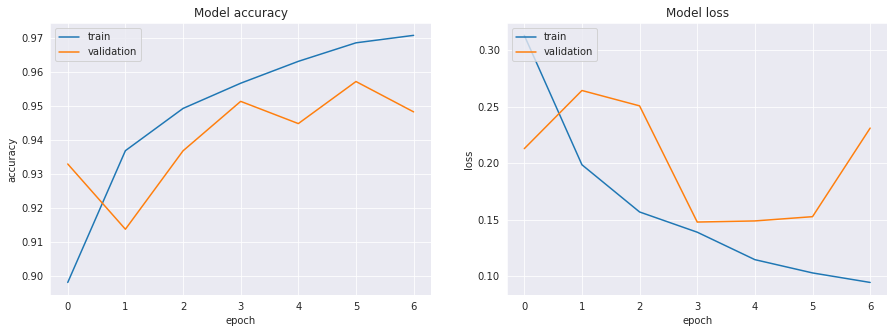

In [25]:
plot_train_history(history)

# Saving Model into TF Lite Format

In [27]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

83262808